# Machine Learning Module

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

os.chdir("../marketdata")
import alpaca

os.chdir("../technicals")
import technicals

In [2]:
test_tickers = ["ADSK"]
ohlcv_df = alpaca.ohlcv(test_tickers)
tech_ind = technicals.TechnicalAnalysis(ohlcv_df)
df = tech_ind.get_all_technicals(test_tickers[0])

In [3]:
df.head()

,open,high,low,close,volume,rsi,williams,mfi,stoch_k,macd,...,ema_7,ema_14,ema_21,highlow,closeopen,bb_high,bb_low,pvt,daily_return,cum_daily_return
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00-05:00,184.21,187.89,181.88,187.83,1379670,0.000000,0.0,0.0,0.0,0.000000,...,187.830000,187.830000,187.830000,6.01,3.62,0.0,0.0,0.000000,0.000000,1.000000
2020-01-03 00:00:00-05:00,184.49,186.41,183.78,184.96,635151,0.000000,0.0,0.0,0.0,-0.064391,...,186.190000,186.292500,186.326667,2.63,0.47,0.0,0.0,0.000000,-0.015280,0.984720
2020-01-06 00:00:00-05:00,183.78,187.25,183.16,187.12,642260,5.101559,0.0,0.0,0.0,-0.015065,...,186.592162,186.608608,186.616677,4.09,3.34,0.0,0.0,17205.405080,0.011678,0.996220
2020-01-07 00:00:00-05:00,186.78,188.17,185.10,187.52,763776,6.052509,0.0,0.0,0.0,0.022180,...,186.931486,186.887428,186.875742,3.07,0.74,0.0,0.0,-5867.743442,0.002138,0.998350
2020-01-08 00:00:00-05:00,188.22,190.50,187.03,190.01,1075388,11.938087,0.0,0.0,0.0,0.141034,...,187.940576,187.702103,187.627387,3.47,1.79,0.0,0.0,12646.931745,0.013279,1.011606


In [4]:
# (X, y) = window_data(df, window_size, 5, 5)

X = np.array(df.drop(columns=["cum_daily_return","open","high","low","close","volume","daily_return"]))
y = np.array(df["close"]).astype(np.float64).reshape(-1, 1)

In [5]:
X.shape

(384, 16)

In [6]:
y.shape

(384, 1)

In [7]:
# Normal train-test split
split = int(0.8 * len(df.index))

X_train = X[: split - 1]
X_test = X[split:]

y_train = y[: split - 1]
y_test = y[split:]

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [9]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
y_train = np.array(y_train).reshape((y_train.shape[0], 1))
y_test = np.array(y_test).reshape((y_test.shape[0], 1))

In [11]:
X_train.shape

(306, 16, 1)

In [12]:
y_train.shape

(306, 1)

In [13]:
window_size = 14

In [14]:
def LSTM(window_size, n_features):
    new_model = keras.Sequential()
    new_model.add(tf.keras.layers.LSTM(100, input_shape=(window_size, n_features), activation='relu'))
    new_model.add(tf.keras.layers.Flatten())
    new_model.add(tf.keras.layers.Dense(1500, activation='relu'))
    new_model.add(tf.keras.layers.Dense(100, activation='linear'))
    new_model.add(tf.keras.layers.Dense(1))
    new_model.compile(optimizer="adam", loss="mean_squared_error")    
    return new_model

In [15]:
n_features = X_train.shape[2]
n_features

1

In [16]:
model = LSTM(window_size=window_size, n_features=n_features)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1500)              151500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               150100    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 342,501
Trainable params: 342,501
Non-trainable params: 0
_________________________________________________________________


In [18]:
modelfit = model.fit(X_train ,y_train, epochs=200, shuffle=False, batch_size=100, verbose=0)

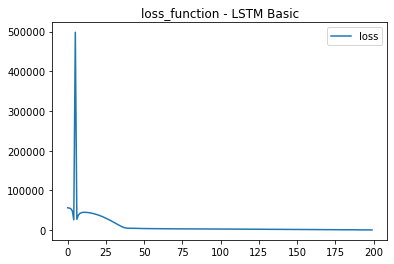

In [19]:
plt.plot(modelfit.history["loss"])
plt.title("loss_function - LSTM Basic")
plt.legend(["loss"])
plt.show()

In [20]:
model.evaluate(X_test, y_test, verbose=0)

72.8460922241211

In [21]:
from sklearn.metrics import r2_score
predictions = model.predict(X_test)
test_r2 = r2_score(y_test, predictions)
test_r2

0.18905520494487627

<AxesSubplot:>

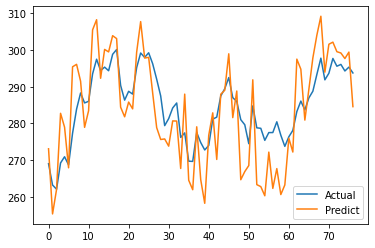

In [22]:
lstm_acc_df = pd.DataFrame()
lstm_acc_df['Actual'] = y_test[:,0]
lstm_acc_df['Predict'] = predictions[:,0]
lstm_acc_df[0:240].plot()